TP SigFox Group:
- Determine the position of device based on the information of sigals
- trainset features : df_mess_train, targets : pos_train
- testset - df_mess_test

Contexte/objectif of problem : A number of devices with GPS equipement move in a zone. The devices communicate with basestations around them by sending messages in an unknown frequence. Now, with the records of these messages, we want to train a machine learning model which allows to predict the device geolocation with a line of message.

A regression problem:

Input - basestation which received the message (id => lat + Ing), rssi (the signal's strength measurement which indicates the distance from the device and the basestation), nseq (unkown feature), time_ux (time at which the basestation received the message)

At the fist step, only information about basestation and rssi useful. A message can be received by multiple basestations. Onehot encoder can represent this as the example notebook. But we want a better one. 

Output- 
lat&Ing which reprents the position in a zone. (need scailling ?)


In [12]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from geopy.distance import vincenty
import seaborn as sns


In [50]:
# load train and test data
df_mess_train = pd.read_csv('mess_train_list.csv') # train set
df_mess_test = pd.read_csv('mess_test_list.csv') # test set
pos_train = pd.read_csv('pos_train_list.csv') # position associated to train set

In [4]:
df_mess_train.head()

,messid,bsid,did,nseq,rssi,time_ux,bs_lat,bs_lng
0,573bf1d9864fce1a9af8c5c9,2841,473335.0,0.5,-121.5,1.463546e+12,39.617794,-104.954917
1,573bf1d9864fce1a9af8c5c9,3526,473335.0,2.0,-125.0,1.463546e+12,39.677251,-104.952721
2,573bf3533e952e19126b256a,2605,473335.0,1.0,-134.0,1.463547e+12,39.612745,-105.008827
3,573c0cd0f0fe6e735a699b93,2610,473953.0,2.0,-132.0,1.463553e+12,39.797969,-105.073460
4,573c0cd0f0fe6e735a699b93,3574,473953.0,1.0,-120.0,1.463553e+12,39.723151,-104.956216


In [5]:
df_mess_train.describe()

,bsid,did,nseq,rssi,time_ux,bs_lat,bs_lng
count,39250.000000,3.925000e+04,39250.000000,39250.000000,3.925000e+04,39250.000000,39250.000000
mean,4533.774752,4.835932e+05,1.043541,-125.863580,1.473368e+12,42.554998,-100.969685
std,2570.495638,9.893140e+04,0.563540,9.226500,5.506910e+09,7.722787,11.522732
min,879.000000,4.732880e+05,0.000000,-155.000000,1.463546e+12,36.053394,-107.463146
25%,2790.000000,4.761230e+05,1.000000,-132.500000,1.468410e+12,39.747448,-105.074287
50%,3559.000000,4.763150e+05,1.000000,-127.333333,1.473444e+12,39.793585,-105.043685
75%,7456.000000,4.766090e+05,1.500000,-121.000000,1.479118e+12,39.838740,-104.998429
max,11951.000000,1.747448e+06,2.000000,-64.000000,1.481143e+12,64.300000,-68.500000


In [4]:
import datetime
print(
    datetime.datetime.fromtimestamp(
        df_mess_train["time_ux"][0]/1000
    ).strftime('%Y-%m-%d %H:%M:%S.%f')
)


2016-05-18 06:38:49.000000


In [5]:
import numpy as np
np.equal(df_mess_train["time_ux"][0], df_mess_train["time_ux"][1])

True

In [6]:
pos_train.head()

,lat,lng
0,39.606690,-104.958490
1,39.606690,-104.958490
2,39.637741,-104.958554
3,39.730417,-104.968940
4,39.730417,-104.968940


In [7]:
pos_train.describe()

,lat,lng
count,39250.000000,39250.000000
mean,39.783333,-105.056343
std,0.206262,0.162954
min,35.770683,-107.630679
25%,39.708599,-105.060463
50%,39.776882,-105.039440
75%,39.805279,-105.018730
max,43.140387,-102.094289


## cleaning 
### get rid of abnormal datas

In [10]:
lat_error=pos_train["lat"]-df_mess_train["bs_lat"]
lng_error=pos_train["lng"]-df_mess_train["bs_lng"]

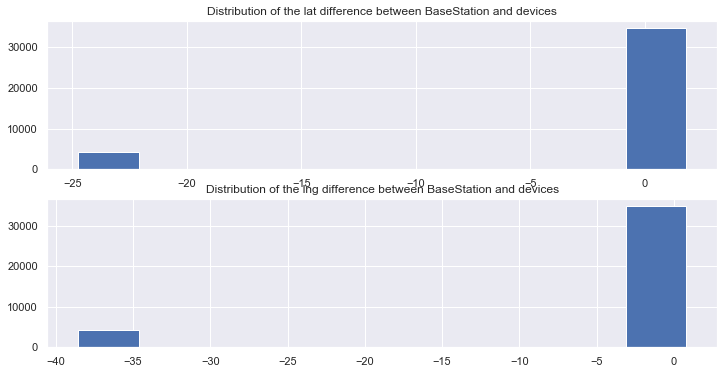

In [25]:
sns.set()
plt.figure(figsize=(12,6))
plt.subplot(2,1,1)
plt.hist(lat_error)
plt.title('Distribution of the lat difference between BaseStation and devices')
plt.subplot(2,1,2)
plt.hist(lng_error)
plt.title('Distribution of the lng difference between BaseStation and devices')
plt.show()

We have to eliminate the data with the device ans base station futher than 200km from each other.

In [52]:
df_mess_train[abs(lat_error) > 3][abs(lng_error) > 3].head()

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


,messid,bsid,did,nseq,rssi,time_ux,bs_lat,bs_lng
5106,57617e1ef0fe6e0c9fd6eb06,8355,476606.0,1.5,-106.5,1.466007e+12,64.3,-68.5
5118,576180cf3e952e04b3b41e5c,8355,476512.0,0.5,-111.5,1.466008e+12,64.3,-68.5
5179,5761a161f0fe6e0c9fec42b9,8355,473683.0,0.0,-126.0,1.466016e+12,64.3,-68.5
5216,57623817864fce5689ec33af,8355,473683.0,0.5,-127.0,1.466055e+12,64.3,-68.5
5416,5763734c864fce5689a422f3,8355,476600.0,1.5,-123.0,1.466135e+12,64.3,-68.5


In [ ]:
df_mess_train[abs(lat_error) > 3][abs(lng_error) > 3].head()

In [54]:
df_mess_train = df_mess_train[abs(lat_error) < 3][abs(lng_error) < 3]
pos_train = pos_train[abs(lat_error) < 3][abs(lng_error) < 3]

//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.
//anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


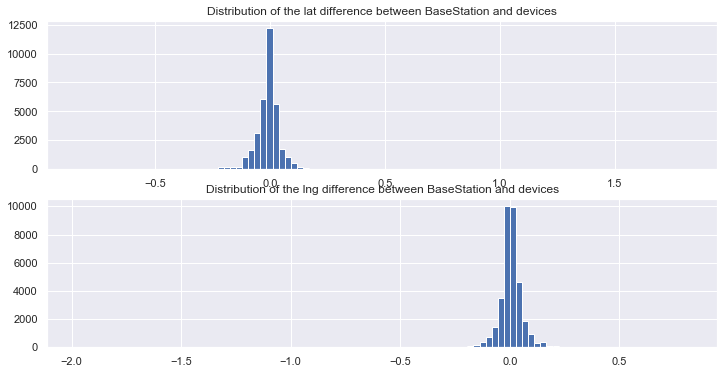

In [59]:
lat_error=pos_train["lat"]-df_mess_train["bs_lat"]
lng_error=pos_train["lng"]-df_mess_train["bs_lng"]
sns.set()
plt.figure(figsize=(12,6))
plt.subplot(2,1,1)
plt.hist(lat_error,bins=100)
plt.title('Distribution of the lat difference between BaseStation and devices')
plt.subplot(2,1,2)
plt.hist(lng_error,bins=100)
plt.title('Distribution of the lng difference between BaseStation and devices')
plt.show()

In [8]:
listOfBs = np.union1d(np.unique(df_mess_train['bsid']), np.unique(df_mess_test['bsid'])) # determine all Base stations that received at least 1 message

In [13]:
listOfDs = np.union1d(np.unique(df_mess_train['did']), np.unique(df_mess_test['did'])) # determine all Devices that sent at least 1 message

In [9]:
len(listOfBs)

259

In [14]:
len(listOfDs)

169

In [34]:
df_mess_train.isna().sum()

messid     0
bsid       0
did        0
nseq       0
rssi       0
time_ux    0
bs_lat     0
bs_lng     0
dtype: int64

There is no nan values.

In [10]:
# Feature Matrix construction 

def feat_mat_const(df_mess_train, listOfBs):

    
    return df_feat

In [11]:
# ground truth construction

def ground_truth_const(df_mess_train, pos_train):


    
    return ground_truth_lat, ground_truth_lng

In [1]:
df_feat = feat_mat_const(df_mess_train, listOfBs)
df_feat.head()

NameError: name 'feat_mat_const' is not defined

In [ ]:
ground_truth_lat, ground_truth_lng = ground_truth_const(df_mess_train, pos_train)
ground_truth_lat.shape

In [ ]:
# Validation

In [ ]:
def regressor_and_predict(df_feat, ground_truth_lat, ground_truth_lng, df_test):
    
    # train regressor and make prediction in the train set
    # Input: df_feat: feature matrix used to train regressor
    #        ground_truth_lat: df_feat associated latitude
    #        ground_truth_lng: df_feat associated longitude
    #        df_test: data frame used for prediction
    # Output: y_pred_lat, y_pred_lng

    
    return y_pred_lat, y_pred_lng


In [ ]:
# Make regressor and prediction using the train set

In [ ]:
y_pred_lat, y_pred_lng = regressor_and_predict(df_feat, ground_truth_lat, ground_truth_lng, df_feat)

In [ ]:
# Cross validation

In [ ]:
# Evaluate result

In [ ]:
def vincenty_vec(vec_coord):
    vin_vec_dist = np.zeros(vec_coord.shape[0])
    if vec_coord.shape[1] !=  4:
        print('ERROR: Bad number of columns (shall be = 4)')
    else:
        vin_vec_dist = [vincenty(vec_coord[m,0:2],vec_coord[m,2:]).meters for m in range(vec_coord.shape[0])]
    return vin_vec_dist

In [ ]:
# evaluate distance error for each predicted point
def Eval_geoloc(y_train_lat , y_train_lng, y_pred_lat, y_pred_lng):
    vec_coord = np.array([y_train_lat , y_train_lng, y_pred_lat, y_pred_lng])
    err_vec = vincenty_vec(np.transpose(vec_coord))
    
    return err_vec

In [ ]:
err_vec = Eval_geoloc(ground_truth_lat , ground_truth_lng, y_pred_lat, y_pred_lng)

In [ ]:
# Plot error distribution

In [ ]:
values, base = np.histogram(err_vec, bins=50000)
cumulative = np.cumsum(values) 
plt.figure();
plt.plot(base[:-1]/1000, cumulative / np.float(np.sum(values))  * 100.0, c='blue')
plt.grid(); plt.xlabel('Distance Error (km)'); plt.ylabel('Cum proba (%)'); plt.axis([0, 30, 0, 100]); 
plt.title('Error Cumulative Probability'); plt.legend( ["Opt LLR", "LLR 95", "LLR 99"])

In [ ]:
# Error criterion

np.percentile(err_vec, 80)

In [ ]:
# Construct test prediction